In [1]:
!pip install opencv-python numpy pandas scikit-learn tensorflow matplotlib seaborn



In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Original QR Codes:


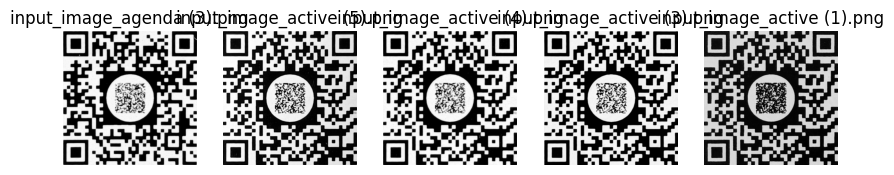

Counterfeit QR Codes:


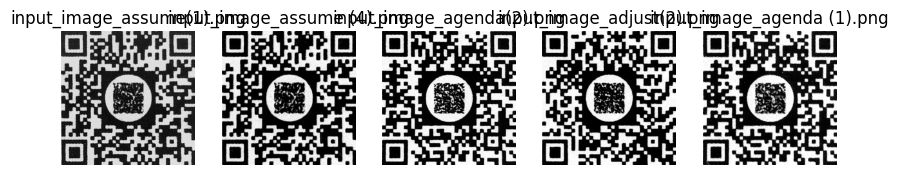

In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_and_display_images(folder_path, num_samples=5):
    images = os.listdir(folder_path)[:num_samples]

    plt.figure(figsize=(10, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder_path, img_name)

        # Check if the file is an image
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
            print(f"Skipping non-image file: {img_name}")
            continue

        # Read the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Handle cases where the image fails to load
        if img is None:
            print(f"Could not read image: {img_name}")
            continue

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(img_name)
        plt.axis("off")

    plt.show()

# Example usage
originals_path = "/content/drive/MyDrive/assignment/First Print-20250325T071108Z-001/First Print"
counterfeits_path = "/content/drive/MyDrive/assignment/Second Print-20250325T071105Z-001/Second Print"

print("Original QR Codes:")
load_and_display_images(originals_path)

print("Counterfeit QR Codes:")
load_and_display_images(counterfeits_path)


In [28]:
original_count = len(os.listdir(originals_path))
counterfeit_count = len(os.listdir(counterfeits_path))

print(f"Number of original QR codes: {original_count}")
print(f"Number of counterfeit QR codes: {counterfeit_count}")


Number of original QR codes: 100
Number of counterfeit QR codes: 100


In [29]:
import os
import cv2
import numpy as np

def extract_features(image_path):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Error handling if the image is not loaded
    if img is None:
        print(f"Error: Unable to load image {image_path}")
        return None

    img = cv2.resize(img, (128, 128))  # Resize to a fixed size

    # Canny Edge Detection
    edges = cv2.Canny(img, 100, 200)

    # Histogram Features
    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()

    return np.concatenate((edges.flatten(), hist))

# Example usage
originals_path = "/content/drive/MyDrive/assignment/First Print-20250325T071108Z-001/First Print"

# Ensure there are images in the directory
image_files = [f for f in os.listdir(originals_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

if not image_files:
    print("Error: No valid images found in the directory.")
else:
    img_path = os.path.join(originals_path, image_files[0])
    features = extract_features(img_path)

    if features is not None:
        print("Extracted Features Shape:", features.shape)



Extracted Features Shape: (16640,)


In [30]:
X = []
y = []

# Process images in both categories
for label, folder in enumerate([originals_path, counterfeits_path]):
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)

        # Skip non-image files
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            print(f"Skipping non-image file: {img_name}")
            continue

        features = extract_features(img_path)

        if features is not None:  # Only append valid feature vectors
            X.append(features)
            y.append(label)

# Convert to NumPy arrays
X = np.array(X, dtype=np.float32)  # Ensure consistent dtype
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset loaded: {len(X_train)} training samples, {len(X_test)} testing samples.")

Dataset loaded: 160 training samples, 40 testing samples.


In [31]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.90      1.00      0.95        19

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



In [43]:
import joblib

# Path to save the Random Forest model
rf_model_path = "/content/drive/MyDrive/assignment/random_forest_model.pkl"
rf_model = joblib.load(rf_model_path)

# Save the trained model
joblib.dump(rf_model, rf_model_path)

print(f"Random Forest model saved at: {rf_model_path}")
print("Random Forest model loaded successfully!")


Random Forest model saved at: /content/drive/MyDrive/assignment/random_forest_model.pkl
Random Forest model loaded successfully!


In [32]:
image_size = (128, 128)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    "/content/drive/MyDrive/assignment",
    target_size=image_size,
    batch_size=32,
    class_mode="binary",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    "/content/drive/MyDrive/assignment",
    target_size=image_size,
    batch_size=32,
    class_mode="binary",
    subset="validation"
)


Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [33]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.fit(train_generator, validation_data=val_generator, epochs=10)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5740 - loss: 2.1728 - val_accuracy: 0.5000 - val_loss: 2.7047
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.5251 - loss: 1.6946 - val_accuracy: 0.5000 - val_loss: 0.6701
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6007 - loss: 0.6341 - val_accuracy: 0.7000 - val_loss: 0.5749
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7853 - loss: 0.5175 - val_accuracy: 0.9250 - val_loss: 0.4059
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8949 - loss: 0.3487 - val_accuracy: 0.8750 - val_loss: 0.2841
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9062 - loss: 0.2581 - val_accuracy: 0.9000 - val_loss: 0.2403
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9151 - loss: 0.2018 - val_accuracy: 0.9500 - val_loss: 0.1979
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9837 - loss: 0.1324 - val_accuracy: 0.9500 - val_loss: 0.1813
Epoch 9/1

In [44]:
# Path to save the CNN model
cnn_model_path = "/content/drive/MyDrive/assignment/qrcode_authentication_cnn.h5"

# Save the trained model
cnn_model.save(cnn_model_path)

print(f"CNN model saved at: {cnn_model_path}")
cnn_model = load_model(cnn_model_path)

print("CNN model loaded successfully!")


CNN model saved at: /content/drive/MyDrive/assignment/qrcode_authentication_cnn.h5


CNN model loaded successfully!


In [51]:
def preprocess_image(image_path, image_size=(128, 128)):
    """
    Preprocess the image for prediction:
    - Reads the image in RGB mode
    - Resizes it to match the model's input
    - Normalizes pixel values
    - Expands dimensions for CNN input
    """
    img = cv2.imread(image_path)  # Read in color (default)

    if img is None:
        print(f"Error: Unable to load image {image_path}")
        return None, None

    img_resized = cv2.resize(img, image_size)  # Resize for CNN

    # Normalize and expand dimensions for CNN
    cnn_input = img_resized / 255.0
    cnn_input = np.expand_dims(cnn_input, axis=0)  # Add batch dimension

    # Extract features for Random Forest (using grayscale)
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img_gray, 100, 200)
    hist = cv2.calcHist([img_gray], [0], None, [256], [0, 256]).flatten()
    rf_input = np.concatenate((edges.flatten(), hist)).reshape(1, -1)

    return cnn_input, rf_input


In [52]:
def predict_qr_code(image_path):
    """
    Predicts whether the given QR code is an Original (First Print) or Counterfeit (Second Print).
    Uses both CNN and Random Forest models for prediction.
    """
    cnn_input, rf_input = preprocess_image(image_path)

    if cnn_input is None or rf_input is None:
        return

    # Predict using CNN Model
    cnn_prediction = cnn_model.predict(cnn_input)[0][0]
    cnn_label = "First Print (Original)" if cnn_prediction < 0.5 else "Second Print (Counterfeit)"

    # Predict using Random Forest Model
    rf_prediction = rf_model.predict(rf_input)[0]
    rf_label = "First Print (Original)" if rf_prediction == 0 else "Second Print (Counterfeit)"

    # Display results
    plt.figure(figsize=(4, 4))
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap="gray")
    plt.title(f"CNN: {cnn_label} | RF: {rf_label}")
    plt.axis("off")
    plt.show()

    print(f"CNN Model Prediction: {cnn_label} (Confidence: {cnn_prediction:.4f})")
    print(f"Random Forest Prediction: {rf_label}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


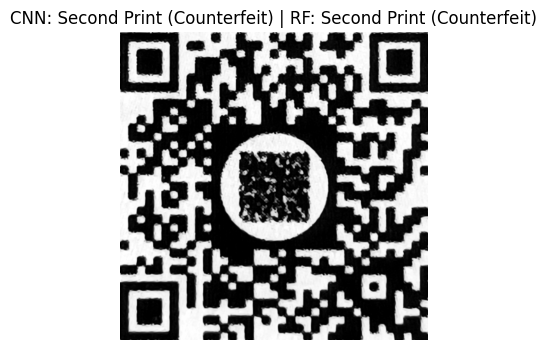

CNN Model Prediction: Second Print (Counterfeit) (Confidence: 0.9968)
Random Forest Prediction: Second Print (Counterfeit)


In [58]:
# Path to a test QR code image with the given dataset
test_image_path = "/content/drive/MyDrive/assignment/Second Print-20250325T071105Z-001/Second Print/input_image_adjust (4).png"

# Run prediction
predict_qr_code(test_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


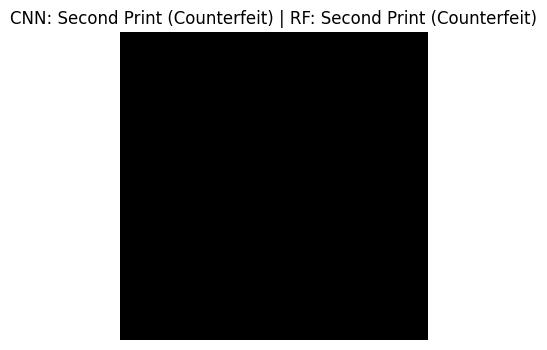

CNN Model Prediction: Second Print (Counterfeit) (Confidence: 0.8883)
Random Forest Prediction: Second Print (Counterfeit)


In [57]:
# Path to a test random QR code image taken from web
test_image_path = "/content/QR_code_for_mobile_English_Wikipedia.svg.png"

# Run prediction
predict_qr_code(test_image_path)


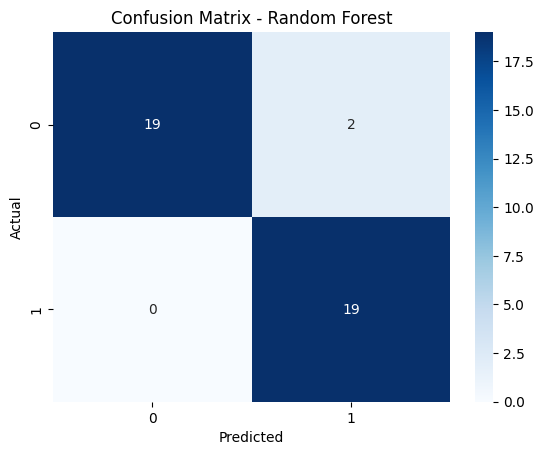

In [34]:
y_pred_rf = rf_model.predict(X_test)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [35]:
cnn_loss, cnn_acc = cnn_model.evaluate(val_generator)
print(f"CNN Model Accuracy: {cnn_acc*100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9458 - loss: 0.1227
CNN Model Accuracy: 95.00%
